# Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Death prediction in Colombia due to covid-19.

In [ ]:
df = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia._20241128.csv')

## 1. Data Collection

The dataset that we found is too big (more than 6.3M of records) and the features are written in spanish, which doesn't help us for cleaning it.

We will then rename columns, and use a small sample (more precisely 1% of the original dataset) to export it to another file.

Doing so, we will have readable input variables in english, and a file that will allow us to use less computing ressources.

### Renaming columns

In [ ]:
column_mapping = {
    "fecha reporte web": "report_date",
    "ID de caso": "case_id",
    "Fecha de notificación": "notification_date",
    "Código DIVIPOLA departamento": "department_code",
    "Nombre departamento": "department_name",
    "Código DIVIPOLA municipio": "municipality_code",
    "Nombre municipio": "municipality_name",
    "Edad": "age",
    "Unidad de medida de edad": "age_unit",
    "Sexo": "gender",
    "Tipo de contagio": "contagion_type",
    "Ubicación del caso": "case_location",
    "Estado": "status",
    "Código ISO del país": "country_iso_code",
    "Nombre del país": "country_name",
    "Recuperado": "recovered",
    "Fecha de inicio de síntomas": "symptom_start_date",
    "Fecha de muerte": "death_date",
    "Fecha de diagnóstico": "diagnosis_date",
    "Fecha de recuperación": "recovery_date",
    "Tipo de recuperación": "recovery_type",
    "Pertenencia étnica": "ethnic_affiliation",
    "Nombre del grupo étnico": "ethnic_group_name",
}
df.rename(columns=column_mapping, inplace=True)

### Keeping 1% of dataset using Random Sampling Technique (from pandas library), and exporting it to another file

In [ ]:
df_sample = df.sample(frac=0.01, random_state=42)

In [ ]:
print(f"Percentage of deaths: {int(df_sample[df_sample['death_date'].notna()]['death_date'].count()) / int(df_sample['case_id'].count()) * 100} %")

#### We notice that, we have a lot of class unbalancing, and then this sample doesn't suit us to build a model, so we are going to re-collect our data from the big dataset, in order to have as much records with death_date as without.

### Sampling the dataset in 2 sub-samples (no-death, & death), and combining them

In [ ]:
df_no_death = df[df['death_date'].isna()]
df_no_death_sample = df_no_death.sample(frac=0.004, random_state=42)

In [ ]:
df_death = df[df['death_date'].notna()]
df_death_sample = df_death.sample(frac=0.13, random_state=42)

In [ ]:
df_final_sample = pd.concat([df_no_death_sample, df_death_sample])
df_final_sample = df_final_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_final_sample.to_csv('covid19_sample.csv', index=False)

In [ ]:
print(f"Percentage of deaths: {int(df_final_sample[df_final_sample['death_date'].notna()]['death_date'].count()) / int(df_final_sample['case_id'].count()) * 100} %")

## 2. Data Understanding

### Loading the sample that we exported previously

In [3]:
df = pd.read_csv('covid19_sample.csv')

### Displaying the dataframe and with additional info

In [4]:
df.shape

(48797, 23)

In [5]:
df

,report_date,case_id,notification_date,department_code,department_name,municipality_code,municipality_name,age,age_unit,gender,...,country_iso_code,country_name,recovered,symptom_start_date,death_date,diagnosis_date,recovery_date,recovery_type,ethnic_affiliation,ethnic_group_name
0,2021-05-27 00:00:00,3303012,2021-05-25 00:00:00,76,VALLE,76318,GUACARI,60,1,F,...,NaN,NaN,Recuperado,2021-05-17 00:00:00,NaN,2021-05-26 00:00:00,2021-06-01 00:00:00,Tiempo,6.0,NaN
1,2020-10-12 00:00:00,912103,2020-10-05 00:00:00,68,SANTANDER,68081,BARRANCABERMEJA,86,1,M,...,NaN,NaN,NaN,2020-09-29 00:00:00,2021-02-12 00:00:00,2020-10-11 00:00:00,NaN,NaN,6.0,NaN
2,2021-03-31 00:00:00,2397852,2021-03-18 00:00:00,8,ATLANTICO,8758,SOLEDAD,40,1,F,...,NaN,NaN,Recuperado,2021-03-16 00:00:00,NaN,2021-03-29 00:00:00,2021-04-01 00:00:00,Tiempo,6.0,NaN
3,2021-05-25 00:00:00,3264190,2021-05-21 00:00:00,11,BOGOTA,11001,BOGOTA,35,1,M,...,NaN,NaN,Recuperado,NaN,NaN,2021-05-22 00:00:00,2021-06-04 00:00:00,Tiempo,6.0,NaN
4,2022-02-07 00:00:00,5974914,2022-01-23 00:00:00,44,GUAJIRA,44001,RIOHACHA,18,1,F,...,NaN,NaN,Recuperado,2022-01-19 00:00:00,NaN,2022-02-03 00:00:00,2022-02-08 00:00:00,Tiempo,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48792,2021-05-26 00:00:00,3282457,2021-05-23 00:00:00,76,VALLE,76001,CALI,66,1,F,...,NaN,NaN,Recuperado,2021-05-14 00:00:00,NaN,2021-05-26 00:00:00,2021-05-28 00:00:00,Tiempo,6.0,NaN
48793,2020-09-25 00:00:00,791713,2020-09-23 00:00:00,76,VALLE,76520,PALMIRA,67,1,M,...,NaN,NaN,Fallecido,2020-09-21 00:00:00,2020-09-28 00:00:00,2020-09-23 00:00:00,NaN,NaN,6.0,NaN
48794,2021-07-13 00:00:00,4542060,2021-07-08 00:00:00,11,BOGOTA,11001,BOGOTA,23,1,M,...,NaN,NaN,NaN,2021-07-04 00:00:00,2021-10-14 00:00:00,2021-07-12 00:00:00,NaN,NaN,6.0,NaN
48795,2021-06-12 00:00:00,3714232,2021-06-03 00:00:00,11,BOGOTA,11001,BOGOTA,19,1,M,...,NaN,NaN,Recuperado,NaN,NaN,2021-06-04 00:00:00,2021-06-17 00:00:00,Tiempo,6.0,NaN


In [6]:
df.head()

,report_date,case_id,notification_date,department_code,department_name,municipality_code,municipality_name,age,age_unit,gender,...,country_iso_code,country_name,recovered,symptom_start_date,death_date,diagnosis_date,recovery_date,recovery_type,ethnic_affiliation,ethnic_group_name
0,2021-05-27 00:00:00,3303012,2021-05-25 00:00:00,76,VALLE,76318,GUACARI,60,1,F,...,NaN,NaN,Recuperado,2021-05-17 00:00:00,NaN,2021-05-26 00:00:00,2021-06-01 00:00:00,Tiempo,6.0,NaN
1,2020-10-12 00:00:00,912103,2020-10-05 00:00:00,68,SANTANDER,68081,BARRANCABERMEJA,86,1,M,...,NaN,NaN,NaN,2020-09-29 00:00:00,2021-02-12 00:00:00,2020-10-11 00:00:00,NaN,NaN,6.0,NaN
2,2021-03-31 00:00:00,2397852,2021-03-18 00:00:00,8,ATLANTICO,8758,SOLEDAD,40,1,F,...,NaN,NaN,Recuperado,2021-03-16 00:00:00,NaN,2021-03-29 00:00:00,2021-04-01 00:00:00,Tiempo,6.0,NaN
3,2021-05-25 00:00:00,3264190,2021-05-21 00:00:00,11,BOGOTA,11001,BOGOTA,35,1,M,...,NaN,NaN,Recuperado,NaN,NaN,2021-05-22 00:00:00,2021-06-04 00:00:00,Tiempo,6.0,NaN
4,2022-02-07 00:00:00,5974914,2022-01-23 00:00:00,44,GUAJIRA,44001,RIOHACHA,18,1,F,...,NaN,NaN,Recuperado,2022-01-19 00:00:00,NaN,2022-02-03 00:00:00,2022-02-08 00:00:00,Tiempo,6.0,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48797 entries, 0 to 48796
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_date         48797 non-null  object 
 1   case_id             48797 non-null  int64  
 2   notification_date   48797 non-null  object 
 3   department_code     48797 non-null  int64  
 4   department_name     48797 non-null  object 
 5   municipality_code   48797 non-null  int64  
 6   municipality_name   48797 non-null  object 
 7   age                 48797 non-null  int64  
 8   age_unit            48797 non-null  int64  
 9   gender              48797 non-null  object 
 10  contagion_type      48797 non-null  object 
 11  case_location       43391 non-null  object 
 12  status              43391 non-null  object 
 13  country_iso_code    39 non-null     float64
 14  country_name        39 non-null     object 
 15  recovered           44063 non-null  object 
 16  symp

In [8]:
df.describe()

,case_id,department_code,municipality_code,age,age_unit,country_iso_code,ethnic_affiliation
count,4.879700e+04,48797.000000,48797.000000,48797.000000,48797.000000,39.000000,48784.000000
mean,3.063136e+06,1333.884399,30586.295018,53.571879,1.004427,567.743590,5.904866
std,1.880610e+06,6040.837648,26888.110392,22.675508,0.072012,334.770677,0.611432
min,1.140000e+02,5.000000,5001.000000,1.000000,1.000000,8.000000,1.000000
25%,1.445576e+06,11.000000,11001.000000,35.000000,1.000000,201.000000,6.000000
50%,2.963218e+06,20.000000,15001.000000,55.000000,1.000000,840.000000,6.000000
75%,4.664492e+06,68.000000,54001.000000,72.000000,1.000000,840.000000,6.000000
max,6.390842e+06,47001.000000,99773.000000,108.000000,3.000000,862.000000,6.000000


### Detect issues that have to be fixed later during the pre-processing part

#### Checking for missing values

In [9]:
df.isnull().sum()

report_date               0
case_id                   0
notification_date         0
department_code           0
department_name           0
municipality_code         0
municipality_name         0
age                       0
age_unit                  0
gender                    0
contagion_type            0
case_location          5406
status                 5406
country_iso_code      48758
country_name          48758
recovered              4734
symptom_start_date     2175
death_date            24826
diagnosis_date           27
recovery_date         23308
recovery_type         23315
ethnic_affiliation       13
ethnic_group_name     48099
dtype: int64

In [10]:
print(f"Percentage of deaths: {int(df[df['death_date'].notna()]['death_date'].count()) / int(df['case_id'].count()) * 100} %")

Percentage of deaths: 49.123921552554464 %


#### Visualize outliers

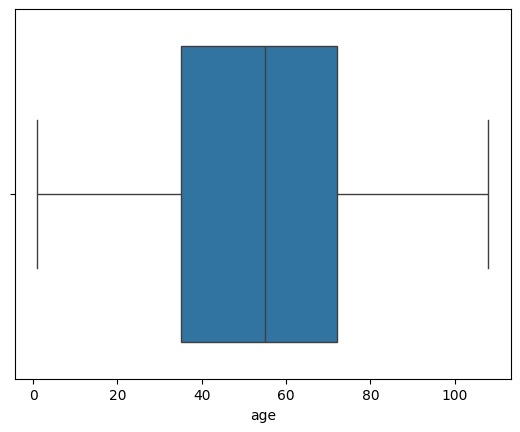

In [11]:
sns.boxplot(data=df, x='age')
plt.show()

#### Visualize distribution

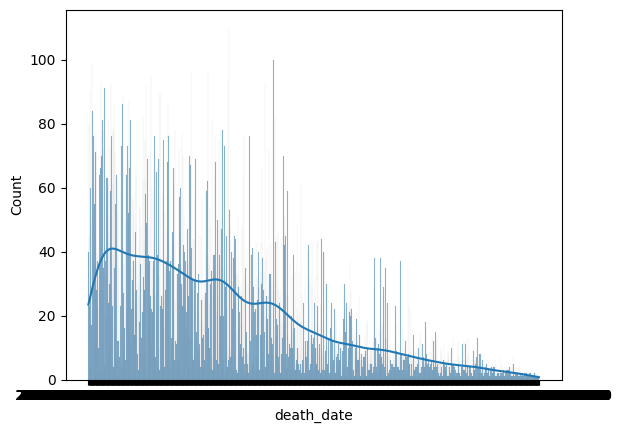

In [13]:
sns.histplot(df['death_date'], kde=True)
plt.show()

#### Detect duplicated records

In [14]:
duplicates = df.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


#### Correlation Analysis with correlation matrix

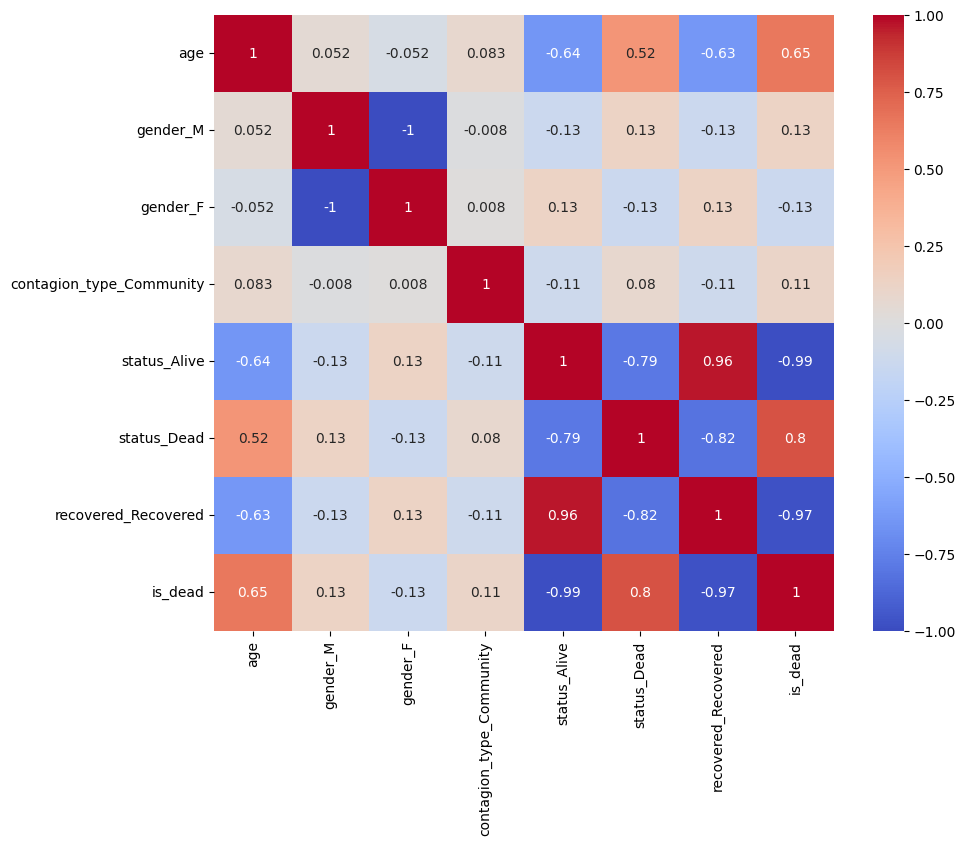

In [22]:
correlation_matrix = df.corr()

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## 3. Data Pre-processing

#### We can see that we have a lot of irrelevant data, missing values, class inbalancing, date columns to be replaced, categorical variables to be encoded, and so on.

So let's clear our data...

### Dropping/filling missing values

df.dropna(axis=0, how='any', inplace=True)

df.dropna(axis=1, how='all', inplace=True)

### OR

df['age'].fillna(df['age'].median(), inplace=True)

and so on...


### Transforming our Target Variable (death_date) to boolean values, and renaming it

In [16]:
df['is_dead'] = df['death_date'].notna()
df.drop(columns=['death_date'], inplace=True)

### Converting date columns

In [17]:
date_columns = ["report_date", "notification_date", "symptom_start_date", "diagnosis_date", "recovery_date"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

### Encoding categorical variables

In [18]:
df = pd.get_dummies(df, columns=["gender", "contagion_type", "status", "recovered"], drop_first=False)

### Filtering relevant features

In [19]:
relevant_features = [
    "age", "gender_M", "gender_F", "contagion_type_Comunitaria", 
    "status_Leve", "status_Fallecido", "recovered_Recuperado", "is_dead"
]
df = df[relevant_features]


### Renaming columns

In [20]:
column_mapping = {
    "contagion_type_Comunitaria": "contagion_type_Community", 
    "status_Leve": "status_Alive",
    "status_Fallecido": "status_Dead",
    "recovered_Recuperado": "recovered_Recovered"
}
df.rename(columns=column_mapping, inplace=True)

### Normalizing numeric features

In [21]:
scaler = StandardScaler()
df['age'] = scaler.fit_transform(df[['age']])

In [ ]:
df.head()